In [ ]:
#default_exp constants.element

In [ ]:
# hide
__file__ = '../../alphabase/constants/element.py'

### `element.yaml` stores chemical element information.

In [ ]:
#export
 
import os
import numpy as np
import numba
import typing

from alphabase.yaml_utils import load_yaml

_base_dir = os.path.dirname(__file__)

MAX_ISOTOPE_LEN = 10
EMPTY_DIST = np.zeros(MAX_ISOTOPE_LEN)
EMPTY_DIST[0] = 1
MASS_PROTON = 1.007276
MASS_ISOTOPE = 1.0033

@numba.njit
def truncate_isotope(
    isotopes: np.array, mono_idx: int
)->typing.Tuple[int, int, int]:
    '''
    For a given isotope distribution (intensity patterns), 
    this function truncates the distribution by top 
    `MAX_ISOTOPE_LEN` neighbors those contain the monoisotopic 
    peak pointed by `mono_idx`.
    Args:
        isotopes (np.array): isotope patterns with size > `MAX_ISOTOPE_LEN`.
        mono_idx (int): where is the monoisotopic peak in the isotope patterns
    Returns:
        int: the new position of `mono_idx`
        int: the start position of the truncated isotopes
        int: the end position of the truncated isotopes
    '''
    trunc_start = mono_idx - 1
    trunc_end = mono_idx + 1
    while trunc_start >= 0 and trunc_end < len(isotopes) and (trunc_end-trunc_start-1)<MAX_ISOTOPE_LEN:
        if isotopes[trunc_end] >= isotopes[trunc_start]:
            trunc_end += 1
        else:
            trunc_start -= 1
    if trunc_end-trunc_start-1 < MAX_ISOTOPE_LEN:
        if trunc_start == -1:
            trunc_end = MAX_ISOTOPE_LEN
        elif trunc_end == len(isotopes):
            trunc_start = len(isotopes)-MAX_ISOTOPE_LEN-1
    return mono_idx-trunc_start-1, trunc_start+1, trunc_end

def reset_elements():
    for elem, items in CHEM_INFO_DICT.items():
        isotopes = np.array(items['abundance'])
        masses = np.array(items['mass'])
        _sort_idx = np.argsort(masses)
        masses = masses[_sort_idx]
        isotopes = isotopes[_sort_idx]
        _mass_pos = np.round(masses).astype(int)
        _mass_pos = _mass_pos - _mass_pos[0]
        if _mass_pos[-1] - _mass_pos[0] + 1 <= MAX_ISOTOPE_LEN:
            _isos = np.zeros(MAX_ISOTOPE_LEN)
            _isos[_mass_pos] = isotopes
            _masses = np.zeros(MAX_ISOTOPE_LEN)
            _masses[_mass_pos] = masses
            mono_idx = np.argmax(_isos)

            CHEM_MONO_MASS[elem] = _masses[mono_idx]
            CHEM_ISOTOPE_DIST[elem] = _isos
            CHEM_MONO_IDX[elem] = mono_idx
        else:
            _isos = np.zeros(_mass_pos[-1] - _mass_pos[0] + 1)
            _isos[_mass_pos] = isotopes
            _masses = np.zeros(_mass_pos[-1] - _mass_pos[0] + 1)
            _masses[_mass_pos] = masses
            mono_idx = np.argmax(_isos)
            CHEM_MONO_MASS[elem] = _masses[mono_idx]

            _mono_idx, start, end = truncate_isotope(_isos, mono_idx)

            CHEM_ISOTOPE_DIST[elem] = _isos[start:end]
            CHEM_MONO_IDX[elem] = _mono_idx

def load_elem_yaml(yaml_file:str):
    '''
    This function can be use to load user-defined `element.yaml` file
    '''
    global CHEM_INFO_DICT
    global CHEM_MONO_MASS
    global CHEM_ISOTOPE_DIST
    global CHEM_MONO_IDX
    global MASS_H2O
    global MASS_NH3

    CHEM_INFO_DICT = load_yaml(yaml_file)

    CHEM_MONO_MASS = {}
    CHEM_ISOTOPE_DIST = numba.typed.Dict.empty(
        key_type=numba.types.unicode_type,
        value_type=numba.types.float64[:]
    )
    
    CHEM_MONO_IDX = numba.typed.Dict.empty(
        key_type=numba.types.unicode_type,
        value_type=numba.types.int64
    )

    reset_elements()
        
    MASS_H2O = CHEM_MONO_MASS['H']*2 + CHEM_MONO_MASS['O']
    MASS_NH3 = CHEM_MONO_MASS['H']*3 + CHEM_MONO_MASS['N']

load_elem_yaml(
    os.path.join(_base_dir,
        'element.yaml'
    )
)

### Calculate mass from a formula
Formula format: `H(1)C(2)O(3)...`

In [ ]:
#export
def parse_formula(formula:str)->typing.List[typing.Tuple[str,float]]:
    '''
    Given a formula (str, e.g. `H(1)C(2)O(3)`), 
    it generates `[('H', 2), ('C', 2), ('O', 1)]`
    '''
    if not formula: return []
    items = [item.split('(') for item in formula.strip(')').split(')')]
    return [(elem, int(n)) for elem, n in items]

def calc_formula_mass(formula:str):
    '''
    Calculates the mass of the formula`
    Args:
        formula (str): e.g. `H(1)C(2)O(3)`
    Returns:
        float: mass of the formula
    '''
    return np.sum([CHEM_MONO_MASS[elem]*n for elem, n in parse_formula(formula)])

Example

In [ ]:
parse_formula('H(2)C(2)O(1)')

[('H', 2), ('C', 2), ('O', 1)]

In [ ]:
calc_formula_mass('H(2)C(2)O(1)')

42.0105633

In [ ]:
calc_formula_mass('')

0.0

### Isotope distribution (in centroid mode)

In [ ]:
#export

@numba.njit
def abundance_convolution(
    d1:np.array,
    mono1:int,
    d2:np.array,
    mono2:int,
)->typing.Tuple[np.array, int]:
    '''
    Args:
        d1 (np.array): isotope distribution to convolute.
        mono1 (int): mono position of d1.
        d2 (np.array): isotope distribution to convolute.
        mono2 (int): mono position of d2
    Returns:
        np.array: convoluted isotope distribution.
        int: new mono position.
    '''
    mono_idx = mono1 + mono2
    ret = np.zeros(MAX_ISOTOPE_LEN*2-1)
    for i in range(len(d1)):
        for j in range(len(d2)):
            ret[i+j] += d1[i]*d2[j]

    mono_idx, start, end = truncate_isotope(ret, mono_idx)
    return ret[start:end], mono_idx

@numba.njit
def one_element_dist(
    elem: str,
    n: int,
    chem_isotope_dist: numba.typed.Dict,
    chem_mono_idx: numba.typed.Dict,
)->typing.Tuple[np.array, int]:
    '''
    Calculate the isotope distribution for an element and its numbers.
    Args:
        elem (str): element.
        n (int): element number.
        chem_isotope_dist (numba.typed.Dict): use `CHEM_ISOTOPE_DIST` as parameter.
        chem_mono_idx (numba.typed.Dict): use `CHEM_MONO_IDX` as parameter.
    Returns:
        np.array: isotope distribution of the element.
        int: mono position in the distribution
    '''
    if n == 0: return EMPTY_DIST.copy(), 0
    elif n == 1: return chem_isotope_dist[elem], chem_mono_idx[elem]
    tmp_dist, mono_idx = one_element_dist(elem, n//2, chem_isotope_dist, chem_mono_idx)
    tmp_dist, mono_idx = abundance_convolution(tmp_dist, mono_idx, tmp_dist, mono_idx)
    if n%2 == 0:
        return tmp_dist, mono_idx
    else:
        return abundance_convolution(tmp_dist, mono_idx, chem_isotope_dist[elem], chem_mono_idx[elem])

In [ ]:
#export
def formula_dist(
    formula_list:typing.List[typing.Tuple[str,int]]
)->typing.Tuple[np.array, int]:
    '''
    Generate the isotope distribution and the mono index for 
    a given formula (as a list, e.g. `[('H', 2), ('C', 2), ('O', 1)]`),
    Args:
        formula_list (list of tuples[str,int]): 
            formula list, e.g. `[('H', 2), ('C', 2), ('O', 1)]`
    Returns:
        np.array: isotope distribution
        int: mono position
    '''
    calc_dist = EMPTY_DIST.copy()
    mono_idx = 0
    for elem, n in formula_list:
        _dist, _mono = one_element_dist(elem, n, CHEM_ISOTOPE_DIST, CHEM_MONO_IDX)
        calc_dist, mono_idx = abundance_convolution(calc_dist, mono_idx, _dist, _mono)
    return calc_dist, mono_idx

## Compare calculated isotope distribution with sisweb.com/mstools/isotope.htm

In [ ]:
dist, mono_idx = one_element_dist('H', 10, CHEM_ISOTOPE_DIST, CHEM_MONO_IDX)
print(mono_idx)
[f'{d*100:.4f}' for d in dist/max(dist)]


0


['100.0000',
 '0.1500',
 '0.0001',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000']

### Desired distribution for H10: (100, 0.16, 0.0001) calculated from sisweb.com/mstools/isotope.htm in low resolution mode (centroid mode)

In [ ]:
dist = np.zeros(MAX_ISOTOPE_LEN)
dist[:3] = [100, 0.16, 0.0001]
[f'{d*100:.4f}' for d in dist/max(dist)]

['100.0000',
 '0.1600',
 '0.0001',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000']

In [ ]:
formula = 'C(100)H(100)O(10)'
formula = [item.split('(') for item in formula.strip(')').split(')')]
formula = [(elem, int(n)) for elem, n in formula]
formula

[('C', 100), ('H', 100), ('O', 10)]

In [ ]:
mass = np.sum([CHEM_MONO_MASS[elem]*n for elem,n in formula])
mass

1460.731601

0


['87.8624',
 '100.0000',
 '58.1497',
 '23.0071',
 '6.9586',
 '1.7138',
 '0.3575',
 '0.0649',
 '0.0104',
 '0.0015']

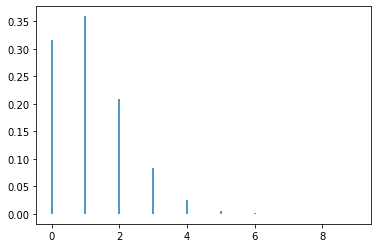

In [ ]:
try:
    import matplotlib.pyplot as plt
except:
    plt = None
calc_dist, mono_idx = formula_dist(formula)
print(mono_idx)

if plt: plt.vlines(np.arange(len(calc_dist)), ymin=np.zeros_like(calc_dist), ymax=calc_dist)
[f'{d*100:.4f}' for d in calc_dist/max(calc_dist)]


### Desired distribution for `C(100)H(100)O(10)`: `(90.7784, 100, 56.368, 21.6475, 6.3624, 1.524, 0.3093)` calculated from sisweb.com/mstools/isotope.htm in low resolution mode (centroid mode)

['90.7784',
 '100.0000',
 '56.3680',
 '21.6475',
 '6.3624',
 '1.5240',
 '0.3093',
 '0.0000',
 '0.0000',
 '0.0000']

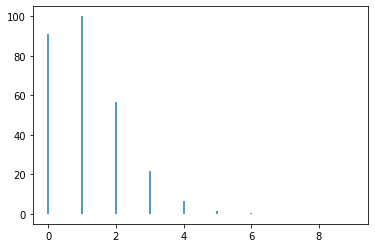

In [ ]:
target_dist = np.zeros(MAX_ISOTOPE_LEN)

target_dist[:7] = [90.7784, 100, 56.368, 21.6475, 6.3624, 1.524, 0.3093]
if plt: plt.vlines(np.arange(len(target_dist)), ymin=np.zeros_like(target_dist), ymax=target_dist)
[f'{d*100:.4f}' for d in target_dist/max(target_dist)]

### The target and calculated distributions are very similar

In [ ]:
cosine = np.sum(calc_dist*target_dist)/np.sum(np.sqrt(calc_dist**2 * target_dist**2))
cosine

1.0

### Compare with Averagine

In [ ]:
averagine_aa = {}
averagine_aa["C"] = 4.9384
averagine_aa["H"] = 7.7583
averagine_aa["N"] = 1.3577
averagine_aa["O"] = 1.4773
averagine_aa["S"] = 0.0417
averagine_avg = 111.1254

nAA = int(mass/averagine_avg)
nH = int(mass - nAA*averagine_avg)
nAA, nH

(13, 16)

['100.0000',
 '80.3436',
 '35.7405',
 '11.4293',
 '2.9118',
 '0.6241',
 '0.1163',
 '0.0193',
 '0.0029',
 '0.0004']

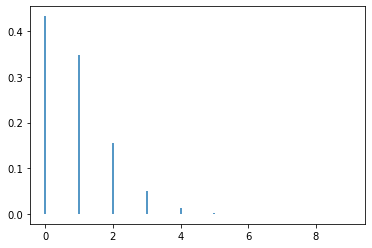

In [ ]:
if nH:
    calc_dist, mono_idx = one_element_dist('H', nH, CHEM_ISOTOPE_DIST, CHEM_MONO_IDX)
else:
    calc_dist = EMPTY_DIST.copy()
    mono_idx = 0
for elem, num in averagine_aa.items():
    n = int(nAA*num)
    _dist, _mono = one_element_dist(elem, n, CHEM_ISOTOPE_DIST, CHEM_MONO_IDX)
    calc_dist, mono_idx = abundance_convolution(calc_dist, mono_idx, _dist, _mono)
if plt: plt.vlines(np.arange(len(calc_dist)), ymin=np.zeros_like(calc_dist), ymax=calc_dist)
[f'{d*100:.4f}' for d in calc_dist/max(calc_dist)]

mono isotope idx is 1


['0.8823',
 '88.3536',
 '100.0000',
 '58.0412',
 '22.9427',
 '6.9352',
 '1.7074',
 '0.3561',
 '0.0646',
 '0.0104']

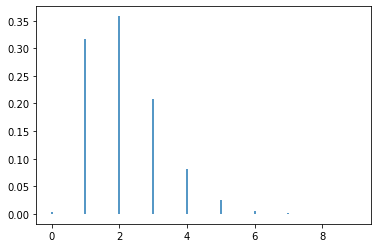

In [ ]:
formula = 'C(100)H(100)O(10)13C(1)'
formula = [item.split('(') for item in formula.strip(')').split(')')]
formula = [(elem, int(n)) for elem, n in formula]

calc_dist, mono_idx = formula_dist(formula)
print(f'mono isotope idx is {mono_idx}')

if plt: plt.vlines(np.arange(len(calc_dist)), ymin=np.zeros_like(calc_dist), ymax=calc_dist)
[f'{d*100:.4f}' for d in calc_dist/max(calc_dist)]